# Imports

In [1]:
import numpy as np
import pandas as pd
import requests as rq
import matplotlib.pyplot as plt
import pickle
from datetime import datetime as dt
from itertools import product

from numpy import ndarray
from pandas import Series

In [2]:
def save_pickle(file_name, object):
    # Open the file in binary write mode
    with open(file_name, 'wb') as file:
        # Use pickle.dump() to export the dictionary to the file
        pickle.dump(object, file)

    print("Dictionary exported successfully.")

def load_pickle(file_name):
    # Importing the dictionary back from the pickle file
    with open(file_name, 'rb') as file:
        loaded_dict = pickle.load(file)

    print("Dictionary imported successfully.")
    
    return loaded_dict

# Data Engineering

## Wheat & Climate Data

In [3]:
# The provided dataset of wheat trade data.
wheat_df = pd.read_excel("YM_wheat_qtr_GTAS Forecasting__20_11_2023.xlsx")
country_codes = pd.read_excel("country_keys.xlsx", names=["Code", "Country"]) # List of country codes copied from worldbank site.

In [4]:
# Merge the shared countries available on both data providers. Manually aligned some countries with similar names in Excel.
target_countries = wheat_df["Export Country/Territory"].drop_duplicates().rename("Country")
merged_countries = pd.merge(country_codes, target_countries, on="Country", how="inner")

# List of different climate measures from climateknowledgeportal.worldbank.org
data_keys = ["hd35", "fd", "tasmax", "tasmin", "tnn", "tas", "sd", "r50mm", "r20mm", "pr"]

In [204]:
# Loop over all the climate data types.
all_data = {}
for data_type in data_keys:
    main_df = pd.DataFrame()
    problems = []

    # Loop over all the matched country codes.
    for code in merged_countries["Code"].iloc[:1]:
        # Need to run try/except given some codes listed on worldbank have no data available (throw error).
        url = f"https://cckpapi.worldbank.org/cckp/v1/cmip6-x0.25_timeseries_{data_type}_timeseries_annual_1950-2014,2015-2100_mean,median_historical,ssp245_ensemble_all_mean/{code}?_format=json"
        res = rq.get(url)
        if res.status_code != 200:
            problems.append([code, res])
            continue
        res = res.json()
        historical = pd.DataFrame(res["data"]["1950-2014"]["median"]["historical"])
        future = pd.DataFrame(res["data"]["2015-2100"]["median"]["ssp245"])
        temp = pd.concat([historical, future], axis=0)
        temp.reset_index(inplace=True)
        temp["index"] = pd.to_datetime(temp["index"].apply(lambda x: x[:4]))
        #temp["index"] = pd.to_datetime(temp["index"])
        temp = temp.rename(columns={"index": "Date"}).set_index("Date", drop=True) # should date be shifted by a year?
        main_df = pd.concat([main_df, temp], axis=1)

    all_data.update({data_type: {"data": main_df, "errors": problems}})

In [615]:
#save_pickle("climate_data_v2.pkl", all_data)

Dictionary exported successfully.


# Climate Analysis

In [156]:
import seaborn as sns
climate = load_pickle("climate_data_v2.pkl")
regions = pd.read_excel("trade_arr.xlsx")[["id", "region"]]
regions["region"].replace("Oceana", "Oceania", inplace=True)
regions_top = pd.merge(regions, country_codes, left_on="id", right_on="Country").drop(columns="id")

regions_all = pd.read_excel("Regions_All.xlsx").rename(columns={"Unnamed: 0": "Country"})
regions_all["region"].replace("Oceana", "Oceania", inplace=True)
regions_unique_codes = regions_all["region"].drop_duplicates().dropna()

Dictionary imported successfully.


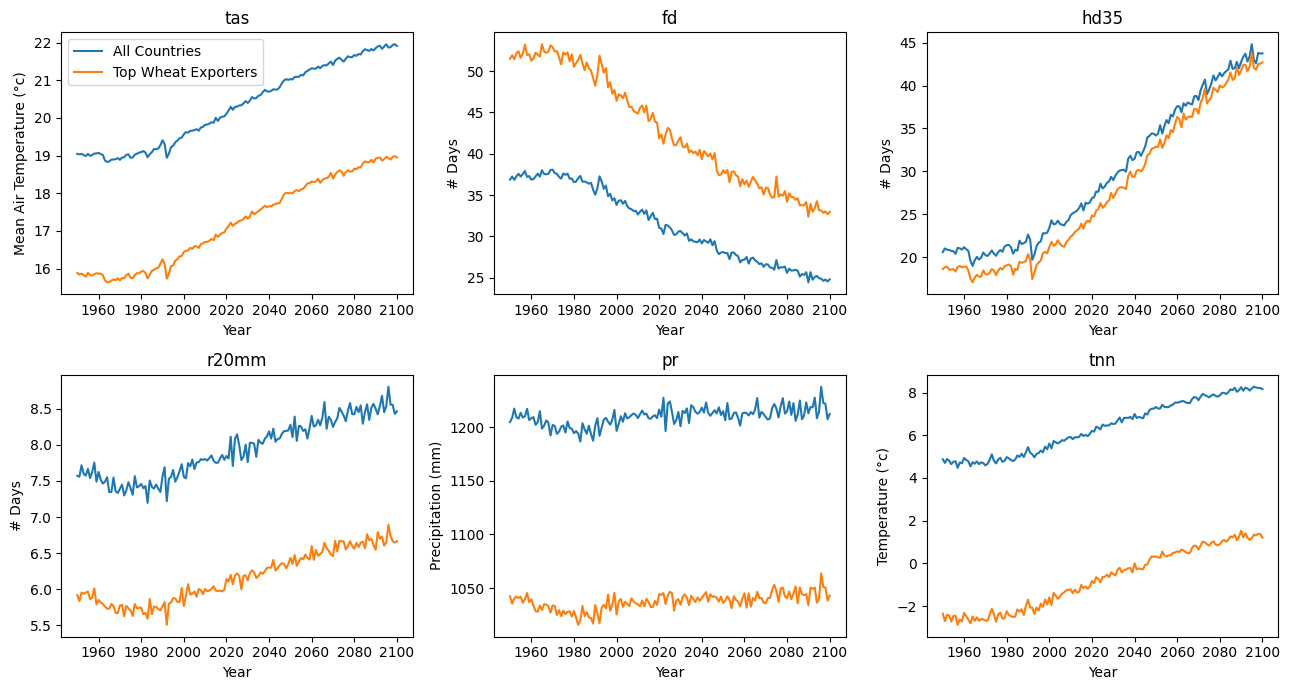

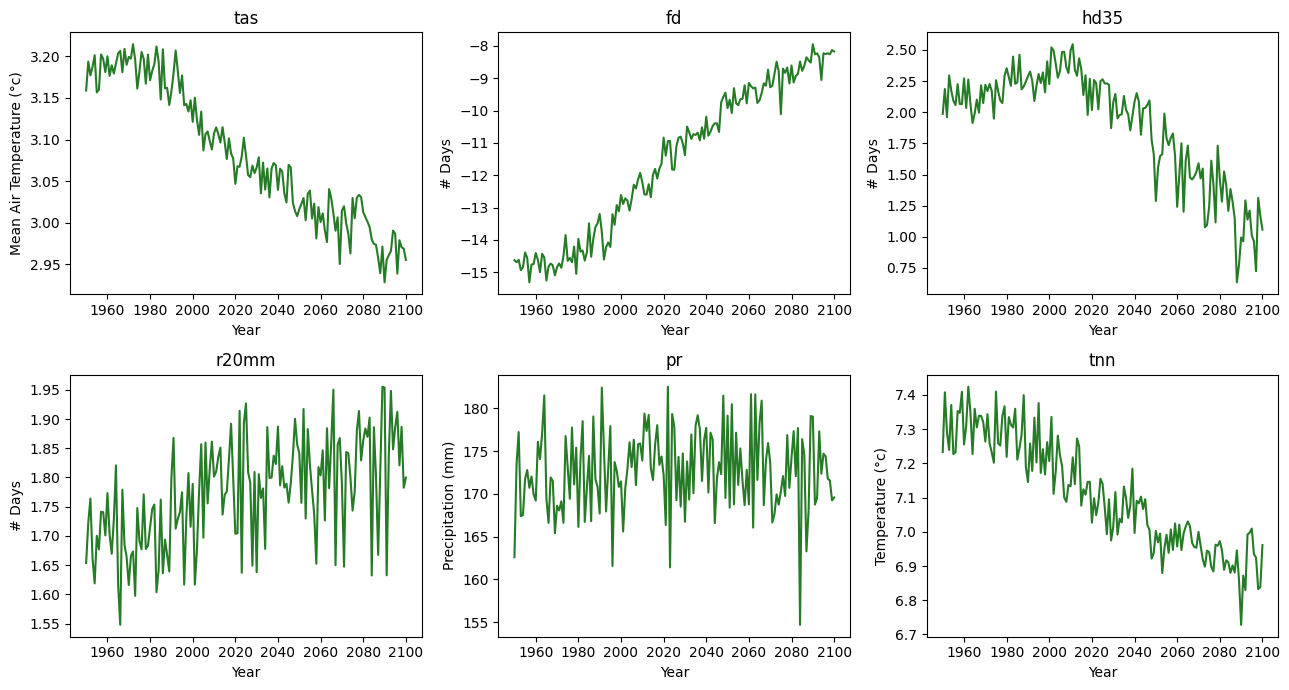

In [425]:
variables = ["tas", "fd", "hd35", "r20mm", "pr", "tnn"]
labels = ["Mean Air Temperature (°c)", "# Days", "# Days", "# Days", "Precipitation (mm)", "Temperature (°c)"]

fig, axes = plt.subplots(2, 3, figsize=(13, 7), tight_layout=True)
axes = axes.flatten()

fig2, axes2 = plt.subplots(2, 3, figsize=(13, 7), tight_layout=True)
axes2 = axes2.flatten()

for ax, ax2, var, lab in zip(axes, axes2, variables, labels):
    x = climate[var]["data"].mean(axis=1)
    y = climate[var]["data"][regions_top["Code"]].mean(axis=1)
    ax.plot(x, label="All Countries")
    ax.plot(y, label="Top Wheat Exporters")
    ax.set_ylabel(lab)
    ax.set_xlabel("Year")
    ax.set_title(var)
    if ax == axes[0]:
        ax.legend()

    ax2.plot(x-y, color="darkgreen", alpha=0.85)
    ax2.set_title(var)
    ax2.set_ylabel(lab)
    ax2.set_xlabel("Year")

fig.savefig("Climate Analytics.png", dpi=190)
fig2.savefig("Climate Analytics Diff.png", dpi=190)

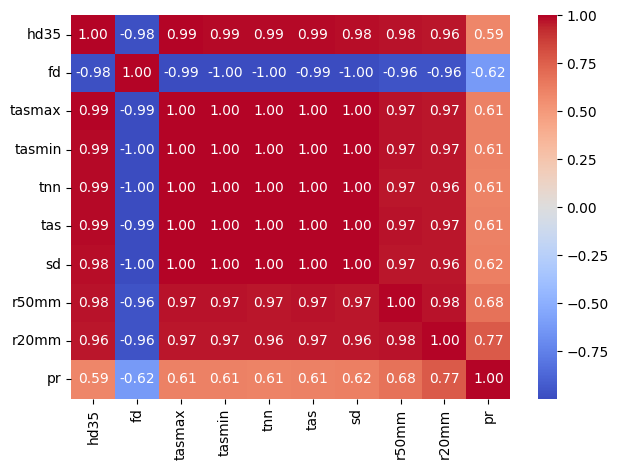

In [118]:
mean_values_all = pd.DataFrame([climate[var]["data"].mean(axis=1).rename(var) for var in data_keys]).T

sns.heatmap(mean_values_all.corr(), annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.tight_layout()
plt.savefig("corr_heatmap.pdf", format="pdf", dpi=190)

In [122]:
climate["tas"]["data"].diff(150-73).iloc[150,:].kurt(), climate["tas"]["data"].diff(73).iloc[73,:].kurt()

(1.0165640648502103, -0.6931474972516356)

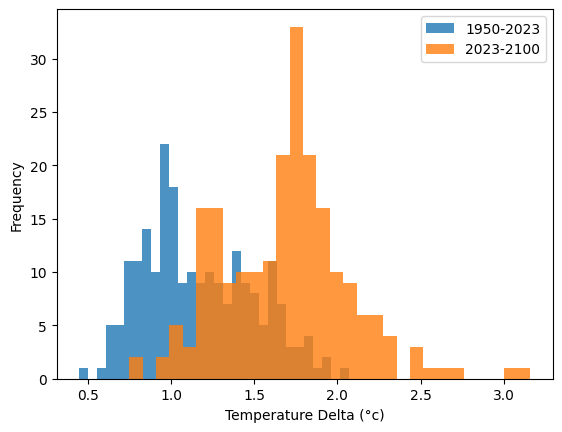

In [117]:
plt.hist(climate["tas"]["data"].diff(73).iloc[73,:], bins=30, alpha=0.8, label="1950-2023")
plt.hist(climate["tas"]["data"].diff(150-73).iloc[150,:], bins=30, alpha=0.8, label="2023-2100")
plt.xlabel("Temperature Delta (°c)")
plt.legend()
plt.ylabel("Frequency")
plt.savefig("temp_delta_dist.pdf", format="pdf", dpi=190)

In [98]:
# Strip plot of temperature change per continent.
master = pd.DataFrame()
data = climate["tas"]["data"]
for region in regions_unique_codes:
    cols = regions_all[regions_all["region"] == region]["Code"]
    cols = [col for col in cols if col in data.columns]
    df = pd.DataFrame(data[cols].diff(150).iloc[-1]).reset_index(drop=True)
    df["Region"] = region
    master = pd.concat([master, df], axis=0)

master = master.rename(columns={master.columns[0]: "Temp Change"})

In [ ]:
# Diminishing returns?

/var/folders/s0/3xfz71116_d8m7n9p2tc7kzc0000gn/T/ipykernel_1222/4175153136.py:14: UserWarning:

FixedFormatter should only be used together with FixedLocator



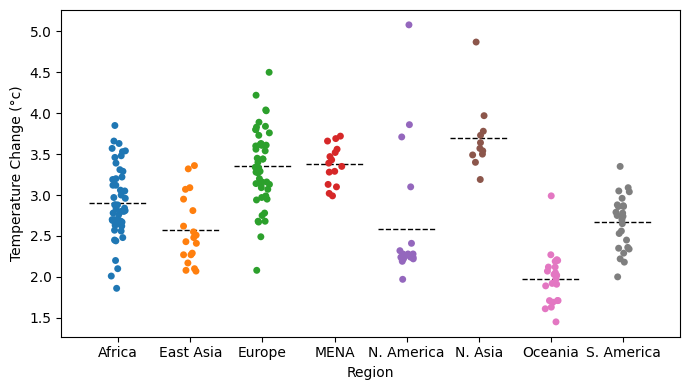

In [142]:
plt.style.use("default")
plt.figure(figsize=(7,4))
sns.stripplot(x="Region", y="Temp Change", hue="Region", data=master.sort_values("Region"))

# Calculate mean values for each category
mean_values = master.groupby("Region")["Temp Change"].mean()

# Plot horizontal lines for mean values for each category.
for i, (region, mean_value) in enumerate(mean_values.items()):
    plt.hlines(y=mean_value, xmin=i - 0.4, xmax=i + 0.4, color='black', linestyle='--', linewidth=1)

custom_labels = ["Africa", "East Asia", "Europe", 'MENA', "N. America", "N. Asia", "Oceania", "S. America"]
ax = plt.gca()
ax.set_xticklabels(custom_labels)

plt.xlabel('Region')
plt.ylabel('Temperature Change (°c)')
plt.tight_layout()
#plt.title('Forecasted Mean Temperature Change by Region')
plt.savefig("temp_change_region.pdf", dpi=190, format="pdf")

# Wheat Analysis

In [6]:
# Need to shift data.
wheat_tons = wheat_df[(wheat_df["Concept"] == "Total Trade Tons") & (wheat_df["Commodity"] != "Wheat")]
wheat_tons = wheat_tons.rename(columns={"Export Country/Territory": "Exporter", "Import Country/Territory": "Importer"})

# Split to find actual exporters – don't run across entire sample.
years = wheat_tons.columns[6:]
wheat_tons = wheat_tons[["Exporter", "Importer"] + [*years]]
wheat_tons = wheat_tons[wheat_tons.isna().sum(axis=1) < 10] # remove countries with more than 10 NaNs.
countries = pd.DataFrame(wheat_tons["Exporter"].drop_duplicates().sort_values().reset_index(drop=True))
date = dt(2020, 1, 1)

In [217]:
network = np.zeros(shape=(len(countries), len(countries)))

for i, country in countries.iterrows():
    partners = pd.DataFrame(countries[~(countries == country[0])]).dropna()
    for j, partner in partners.iterrows():
        if network[i, j] == 0:

            temp_exp_ij = wheat_tons[
                (wheat_tons["Exporter"] == country[0]) & (wheat_tons["Importer"] == partner[0])
                ][date].values
            if temp_exp_ij != None:
                exp_ij = temp_exp_ij
            else:
                exp_ij = -1

            temp_imp_ij = wheat_tons[
                (wheat_tons["Importer"] == country[0]) & (wheat_tons["Exporter"] == partner[0])
                ][date].values
            if temp_imp_ij != None:
                imp_ij = temp_imp_ij
            else:
                imp_ij = -1

            network[i, j] = network[j, i] = exp_ij + imp_ij

/var/folders/s0/3xfz71116_d8m7n9p2tc7kzc0000gn/T/ipykernel_5871/3511645755.py:11: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if temp_exp_ij != None:
/var/folders/s0/3xfz71116_d8m7n9p2tc7kzc0000gn/T/ipykernel_5871/3511645755.py:19: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if temp_imp_ij != None:
/var/folders/s0/3xfz71116_d8m7n9p2tc7kzc0000gn/T/ipykernel_5871/3511645755.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  network[i, j] = network[j, i] = exp_ij + imp_ij
/var/folders/s0/3xfz71116_d8m7n9p2tc7kzc0000gn/T/ipykerne

In [242]:
network_df = pd.DataFrame(network, columns=countries["Exporter"].to_list(), index=countries["Exporter"].to_list()).replace(-2,0).fillna(0)
network_df

,Afghanistan,Albania,Algeria,American Samoa,Angola,Antigua and Barbuda,"Areas, not elsewhere specified",Argentina,Armenia,Aruba,...,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank,Western Samoa,World Total,Yemen,Zambia,Zimbabwe
Afghanistan,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000e+00,0.000000,0.0,...,0.000000,135359.620378,0.000000,0.000000e+00,0.000000,0.000000,1.392258e+06,0.000000,0.000000,0.000000
Albania,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000e+00,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,2.978705e+04,0.000000,0.000000,0.000000
Algeria,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000e+00,0.000000,0.0,...,0.000000,0.000000,0.000000,1.639139e+02,0.000000,0.000000,5.334142e+04,0.000000,0.000000,0.000000
American Samoa,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000e+00,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,4.857124e+02,0.000000,0.000000,0.000000
Angola,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000e+00,0.000000,0.0,...,0.000000,0.000000,0.000000,5.917067e+01,0.000000,0.000000,4.481940e+05,0.000000,59.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Western Samoa,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000e+00,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.154041e+04,0.000000,0.000000,0.000000
World Total,1.392258e+06,29787.049972,53341.424624,485.712373,448194.009822,2034.04101,411244.496579,1.416045e+06,38016.538835,0.0,...,521875.025846,552411.622157,354307.421423,1.929283e+06,514.798998,11540.408139,0.000000e+00,652711.598033,63339.666500,166819.908054
Yemen,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.00000,2207.342371,0.000000e+00,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,6.527116e+05,0.000000,0.000000,0.000000
Zambia,0.000000e+00,0.000000,0.000000,0.000000,59.000000,0.00000,0.000000,0.000000e+00,0.000000,0.0,...,0.000000,0.000000,0.000000,1.000000e+00,0.000000,0.000000,6.333967e+04,0.000000,0.000000,1321.182968


# Jaal/pyvis/Data Generation

In [7]:
from jaal import Jaal
import networkx as nx
from pyvis.network import Network

/Users/adamkeys/opt/anaconda3/envs/quant/lib/python3.9/site-packages/dash_bootstrap_components/_table.py:5: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


In [224]:
color_map = {
    "North America": "lightblue",
    "North Asia": "green",
    "East Asia": "red",
    "Oceania": "purple",
    "Europe": "lightgreen",
    "Africa": "grey",
    "South America": "#feaca6",
    "MENA": "yellow"
}
color_map_ar = {
    "North America": "#70a7cf",  # slightly darker shade of lightblue
    "North Asia": "#006400",     # slightly darker shade of green
    "East Asia": "#8b0000",      # slightly darker shade of red
    "Oceania": "#800080",        # slightly darker shade of purple
    "Europe": "#90ee90",         # slightly darker shade of lightgreen
    "Africa": "black",         # slightly darker shade of brown
    "South America": "#e8cfc4",  # slightly darker shade of lightred
    "MENA": "#ffd700"            # slightly lighter shade of yellow
}

In [ ]:
#–––––––––––––––- Undirected Graph Creator ––––––––––––––––––– #
arr = []
arr_weights = []

for i, country in countries.iterrows():
    partners = pd.DataFrame(countries[~(countries == country[0])]).dropna()
    if country[0] == "World Total":
        continue
    for j, partner in partners.iterrows():
        if (partner[0] == "World Total") or ([partner[0], country[0]] in arr):
            continue
        temp_exp_ij = wheat_tons[
            (wheat_tons["Exporter"] == country[0]) & (wheat_tons["Importer"] == partner[0])
            ][date].values
        if temp_exp_ij != None:
            exp_ij = temp_exp_ij
        else:
            exp_ij = -1

        temp_imp_ij = wheat_tons[
            (wheat_tons["Importer"] == country[0]) & (wheat_tons["Exporter"] == partner[0])
            ][date].values
        if temp_imp_ij != None:
            imp_ij = temp_imp_ij
        else:
            imp_ij = -1

        total = exp_ij + imp_ij
        if total > 0:
            arr.append([country[0], partner[0]])
            arr_weights.append([total])

#arr_df = pd.DataFrame(arr, columns=["from", "to"])
#arr_df = pd.concat([arr_df, pd.Series(arr_weights).rename("weight")], axis=1)
#arr_df["weight"] = arr_df["weight"].apply(lambda x: x[0][0])

In [123]:
#–––––––––––––––- Directed Graph Creator ––––––––––––––––––– #

def directed_graph(countries, wheat_tons, date):
    arr = []
    for i, country in countries.iterrows():
        partners = pd.DataFrame(countries[~(countries == country[0])]).dropna()
        if country[0] == "World Total":
            continue
        for j, partner in partners.iterrows():
            if partner[0] == "World Total":
                continue
            temp_exp_ij = wheat_tons[
                (wheat_tons["Exporter"] == country[0]) & (wheat_tons["Importer"] == partner[0])
                ][date].values
            if temp_exp_ij.size > 0:
                exp_ij = temp_exp_ij
            else:
                exp_ij = -1

            if exp_ij > 0:
                arr.append([country[0], partner[0], exp_ij[0]])

    return pd.DataFrame(arr, columns=["from", "to", "weight"])

In [507]:
date = dt(2023, 1, 1)
arr_df = directed_graph(countries, wheat_tons, date)

In [490]:
arr_filtered = arr_df[arr_df["from"].isin(regions_all.dropna()["Country"])]
arr_filtered = arr_filtered[arr_filtered["to"].isin(regions_all.dropna()["Country"])]
quantile = arr_df["weight"].quantile(0.98)
arr_filtered = arr_filtered[arr_filtered["weight"] > quantile]
nodes = pd.concat([arr_filtered["from"], arr_filtered["to"]], axis=0).drop_duplicates().rename("id")

trade_arr = []
for node in nodes:
    exp = arr_df[arr_df["from"] == node]["weight"].sum()
    imp = arr_df[arr_df["to"] == node]["weight"].sum()
    trade_arr.append([node, exp, imp])

trade_arr = pd.DataFrame(trade_arr, columns=["id", "exp", "imp"])
trade_arr["total"] = trade_arr["exp"] + trade_arr["imp"]
trade_arr = pd.merge(regions_all[["Country", "region"]], trade_arr, left_on="Country", right_on="id").drop(columns="Country")

In [491]:
arr_filtered["weight"].mean()

226880.62122992732

In [487]:
pd.concat([arr_filtered["from"], arr_filtered["to"]], axis=0).drop_duplicates()

45                 Argentina
79                 Australia
143                  Austria
283                  Belgium
594                   Canada
718         China (mainland)
1023      Dominican Republic
1191                  France
1329                 Germany
1615                 Hungary
1681                   India
1777               Indonesia
1909                   Italy
2049                  Jordan
2064              Kazakhstan
2090                    Laos
2390                  Mexico
2431                 Myanmar
2456             Netherlands
2865                  Poland
2965                Portugal
3065                  Rwanda
3180                Slovakia
3263            South Africa
3383                   Spain
3518                  Sweden
3700                Thailand
3872                  Turkey
4175          United Kingdom
4246           United States
4341                 Uruguay
4375                 Vietnam
45                   Bolivia
46                    Brazil
47            

In [240]:
#Jaal(arr_filtered, trade_arr).plot(directed=True, vis_opts={'physics': {'stabilization': False, 'barnesHut': {'centralGravity': 1, 'springConstant': 0.01}}})
#Jaal(arr_filtered, trade_arr).plot(directed=True)

In [241]:
nt = Network('950px', '100%', bgcolor="white", directed=True)

for row in trade_arr.iterrows():
    nt.add_node(row[1]["id"], value=row[1]["total"],  color=color_map[row[1]["region"]])

for row in arr_filtered.iterrows():
    region = regions_all[regions_all["Country"] == row[1]["from"]]["region"].values[0]
    nt.add_edge(row[1]["from"], row[1]["to"], value=row[1]["weight"], color=color_map_ar[region])

nt.show_buttons(filter_=["physics"])
nt.save_graph("test.html")

In [246]:
# ––––––––––--------- Degree Distribution ------------------ #
from scipy.stats import norm, lognorm, anderson, kstest
from geopy.distance import distance

dates = [dt(2005,1,1), dt(2023,1,1), dt(2040, 1, 1)]
arr_arr = [directed_graph(countries, wheat_tons, date) for date in dates]

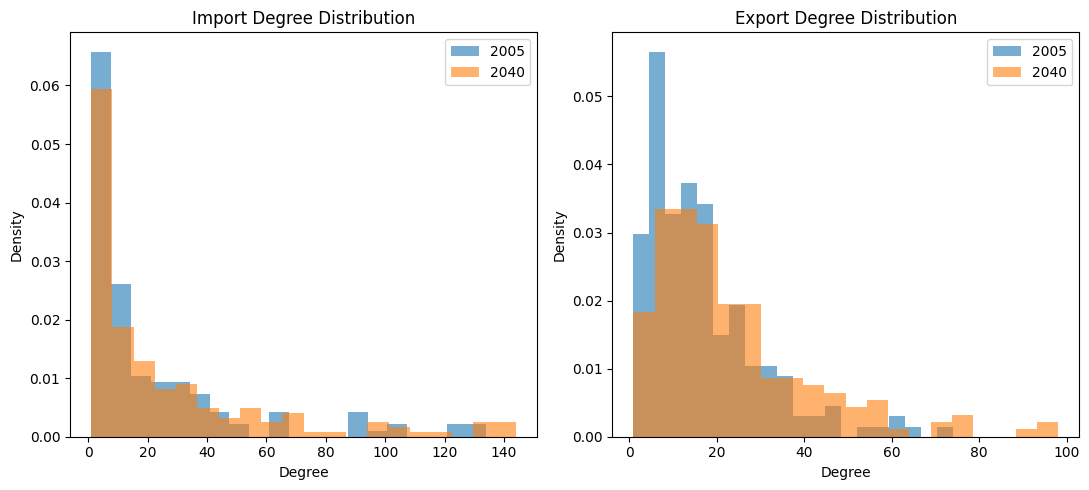

In [435]:
fig, axes = plt.subplots(1,2, figsize=(11,5), tight_layout=True)
hist_from = [arr_arr[i]["from"].value_counts().values for i in range(3)]
hist_to = [arr_arr[i]["to"].value_counts().values for i in range(3)]
axes[0].hist(hist_from[0], bins=20, alpha=0.6, density=True, label="2005")
axes[0].hist(hist_from[2], bins=20, alpha=0.6, density=True, label="2040")
axes[0].set_title("Import Degree Distribution")
axes[1].hist(hist_to[0], bins=20, alpha=0.6, density=True, label="2005")
axes[1].hist(hist_to[2], bins=20, alpha=0.6, density=True, label="2040")
axes[1].set_title("Export Degree Distribution")
for axis in axes.flatten():
    axis.set_ylabel("Density")
    axis.set_xlabel("Degree")
    axis.legend()
plt.savefig("density_distros.pdf", format="pdf", dpi=190)

In [264]:
from scipy.special import kl_div

In [369]:
def MLE_lognormal(data):
    ln_data = np.log(data)
    mu = np.mean(ln_data)
    sigma = np.std(ln_data)

    return mu, sigma

def lognormal_KLD(data, n):
    params = MLE_lognormal(data)
    hist, bins = np.histogram(data, bins=n, density=True)
    x = np.linspace(data.min(),data.max(),n)
    y_hat = lognorm(params[0], params[1]).pdf(x)
    return np.sum(kl_div(hist, y_hat)[1:])

In [327]:
date_range = [dt(x,1,1) for x in range(2005,2041)]
graphs_all_years = [directed_graph(countries, wheat_tons, date) for date in date_range]
save_pickle("graphs_all_years.pkl", graphs_all_years)

Dictionary exported successfully.


In [451]:
vertices_n, edges_n = [], []
for year in graphs_all_years:
    edges_n.append(len(year))
    vertices_n.append(len(pd.concat([year["from"], year["to"]], axis=0).drop_duplicates()))

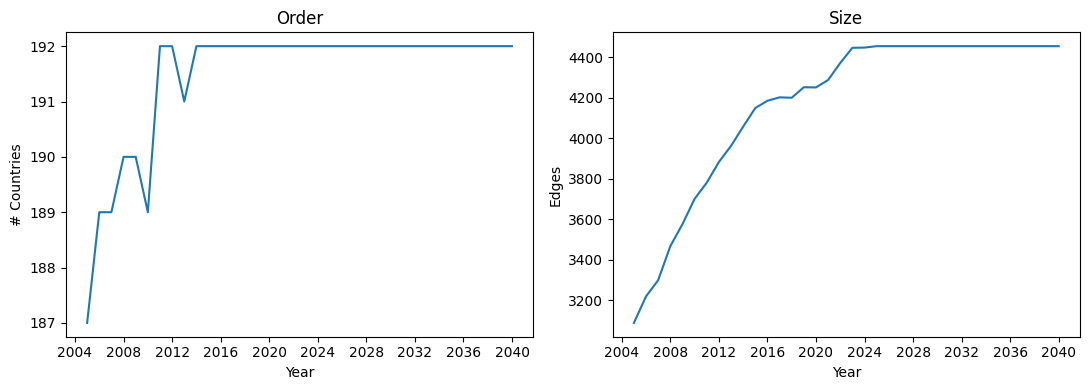

In [496]:
fig, axes = plt.subplots(1,2, figsize=(11,4), tight_layout=True)
axes[0].plot(years, vertices_n)
axes[0].set_title("Order")
axes[0].set_ylabel("# Countries")
axes[1].plot(years, edges_n)
axes[1].set_title("Size")
axes[1].set_ylabel("Edges")
_ = [axes[i].set_xlabel("Year") for i in range(2)]
fig.savefig("order_size.pdf", format="pdf", dpi=190)

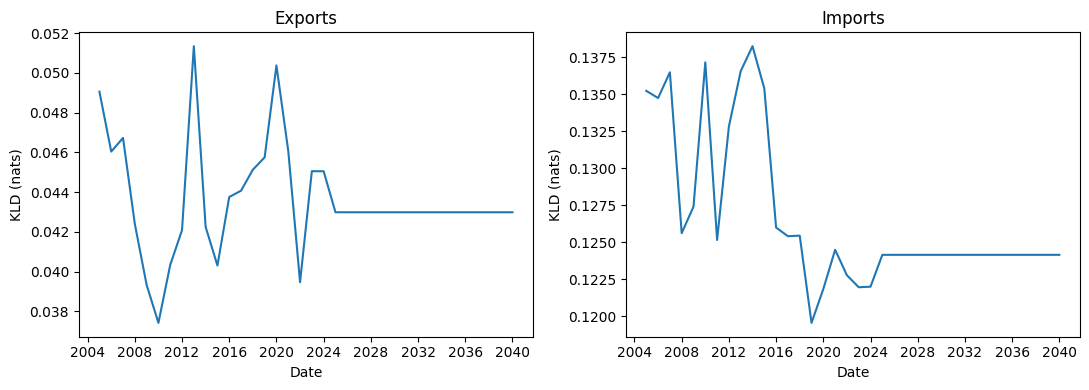

In [436]:
res_from, res_to = [], []
for year in graphs_all_years:
    data = year["from"].value_counts().values
    res_from.append(lognormal_KLD(data, n=20))

    data = year["to"].value_counts().values
    res_to.append(lognormal_KLD(data, n=20))

fig, axes = plt.subplots(1,2, figsize=(11,4), tight_layout=True)
axes[0].plot(date_range, res_from)
axes[0].set_ylabel("KLD (nats)")
axes[0].set_xlabel("Date")
axes[0].set_title("Exports")
axes[1].plot(date_range, res_to)
axes[1].set_ylabel("KLD (nats)")
axes[1].set_xlabel("Date")
axes[1].set_title("Imports")
plt.savefig("lognorm_KLD.pdf", format="pdf", dpi=190)

In [500]:
x = graphs_all_years[-1]["to"].value_counts().values
kstest(np.log(x), norm.pdf), anderson(np.log(x))

(KstestResult(statistic=0.9999891343261229, pvalue=0.0, statistic_location=4.584967478670572, statistic_sign=1),
 AndersonResult(statistic=1.3076336171792775, critical_values=array([0.565, 0.643, 0.771, 0.9  , 1.07 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=2.8281535660346124, scale=0.8794774707047507)
  success: True
  message: '`anderson` successfully fit the distribution to the data.'))

Kullback-Liebler across time?

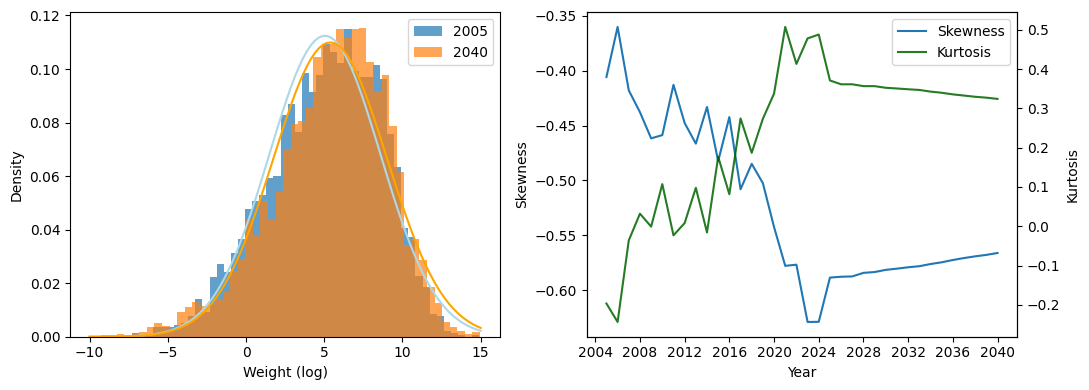

In [433]:
# ––––––––––––––––––––- Weight (trade) Distribution –––––––––––––––––– #
x=np.linspace(-10,15,100)
fig, axes = plt.subplots(1,2, figsize=(11,4), tight_layout=True)

logged = [np.log(graphs_all_years[i]["weight"]) for i in [0,-1]]
axes[0].hist(logged[0], bins=50, density=True, alpha=0.7, label="2005")
axes[0].hist(logged[1], bins=50, density=True, alpha=0.7, label="2040")
curves = [norm(logged[i].mean(), logged[i].std()) for i in range(2)]
axes[0].plot(x, curves[0].pdf(x), color="lightblue")
axes[0].plot(x, curves[1].pdf(x), color="orange")
axes[0].set_xlabel("Weight (log)")
axes[0].set_ylabel("Density")
axes[0].legend()

skews = [np.log(year["weight"]).skew() for year in graphs_all_years]
kurts = [np.log(year["weight"]).kurt() for year in graphs_all_years]
axes[1].plot(years, skews, label="Skewness")
axes2 = axes[1].twinx()
axes2.plot(years, kurts, color="darkgreen", alpha=0.85, label="Kurtosis")
axes[1].set_ylabel("Skewness")
axes2.set_ylabel("Kurtosis")
labels = [x + y for x,y in zip(axes[1].get_legend_handles_labels(), axes2.get_legend_handles_labels())]
axes[1].legend(labels[0], labels[1])
axes[1].set_xlabel("Year")
plt.savefig("weight_distros.pdf", format="pdf", dpi=190)

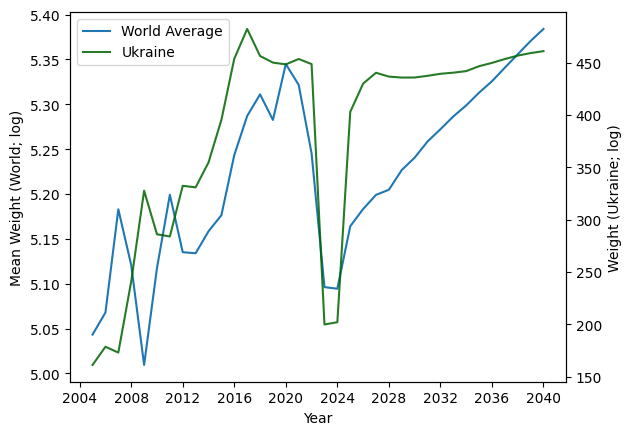

In [431]:
means = [np.log(year["weight"]).mean() for year in graphs_all_years]
ukraine_exp = []
for year in graphs_all_years:
    ukraine = np.sum(np.log(year[year["from"] == "Ukraine"]["weight"]))
    ukraine_exp.append(ukraine)

fig, axes = plt.subplots()
axes.plot(years, means, label="World Average")
axes2 = axes.twinx()
axes2.plot(years, ukraine_exp, color="darkgreen", alpha=0.85, label="Ukraine")
labels = [x + y for x,y in zip(axes.get_legend_handles_labels(), axes2.get_legend_handles_labels())]
axes.legend(labels[0], labels[1])
axes.set_ylabel("Mean Weight (World; log)")
axes2.set_ylabel("Weight (Ukraine; log)")
axes.set_xlabel("Year")
plt.savefig("mean_weight_evol.pdf", format="pdf", dpi=190)

In [178]:
kstest(logged, norm.pdf), anderson(logged)

(KstestResult(statistic=1.0, pvalue=0.0, statistic_location=14.395239289770998, statistic_sign=1),
 AndersonResult(statistic=15.527284347595923, critical_values=array([0.575, 0.655, 0.786, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=5.344934701083251, scale=3.4422028699534293)
  success: True
  message: '`anderson` successfully fit the distribution to the data.'))

# Geographic Analysis

In [438]:
from geopy.distance import distance
import statsmodels.api as sm
geog_data = pd.read_csv("countries.csv")
geog_data_m = pd.merge(countries, geog_data, left_on="Exporter", right_on="name")[["Exporter", "latitude", "longitude"]].set_index("Exporter")

In [508]:
def add_distances(geog_data_m, arr_df):
    unique_combos = []
    for combo in product(geog_data_m.index, geog_data_m.index):
        if ((combo[1], combo[0]) not in unique_combos) and (combo[0] != combo[1]):
            unique_combos.append(list(combo))

    keys = ["latitude", "longitude"]
    for combo in unique_combos:
        combo.append(distance(geog_data_m.loc[combo[0]][keys], geog_data_m.loc[combo[1]][keys]).km)

    combo_distances = pd.DataFrame(unique_combos, columns=["from", "to", "distance"])
    combo_distances = combo_distances.set_index(["from", "to"])

    # Can't merge directly given array contains only unique pairings.
    distances = []
    for i in range(arr_df.shape[0]):
        temp = arr_df.iloc[i][["from", "to"]]

        if tuple(temp.to_list()) in combo_distances.index:
            distances.append(combo_distances.loc[[temp]].values[0][0])
        elif (temp[1], temp[0]) in combo_distances.index:
            distances.append(combo_distances.loc[temp[1], temp[0]].values[0][0])
        else:
            distances.append(0)

    return pd.concat([arr_df, pd.Series(distances).rename("distance")], axis=1)

In [509]:
arr_df_dist = add_distances(geog_data_m, arr_df)
arr_df_non0 = arr_df_dist[arr_df_dist["distance"] != 0]

## Regression Analysis

In [515]:
import statsmodels.regression.linear_model as lm

In [663]:
exog = sm.add_constant(np.log(arr_df_non0["distance"]))
model = lm.OLS(endog=np.log(arr_df_non0["weight"]), exog=exog, hasconst=True)
res = model.fit(cov_type='HC3')
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 weight   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     251.7
Date:                Sun, 14 Apr 2024   Prob (F-statistic):           3.81e-55
Time:                        21:47:47   Log-Likelihood:                -11653.
No. Observations:                4337   AIC:                         2.331e+04
Df Residuals:                    4335   BIC:                         2.332e+04
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.0225      0.437     27.510      0.0

In [645]:
resid1 = res.resid.rolling(100).std()

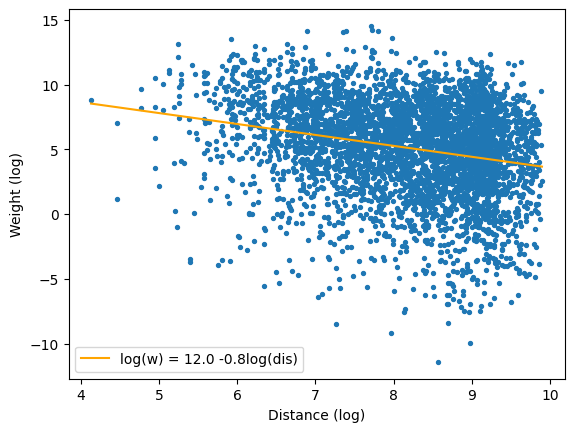

In [530]:
plt.scatter(exog["distance"], np.log(arr_df_non0["weight"]), s=8)
x = np.linspace(exog["distance"].min(), exog["distance"].max(), 100)
plt.plot(x, res.params[0] + res.params[1]*x, color="orange", label=f"log(w) = {round(res.params[0],1)} {round(res.params[1],1)}log(dis)")
plt.ylabel("Weight (log)")
plt.xlabel("Distance (log)")
plt.legend()
plt.savefig("scatter_full.pdf", format="pdf", dpi=190)

In [384]:
import seaborn as sns
# Do strip plots for distribution viewing across different categories.
# Plot the different regression robustness statistics.

In [ ]:
date_range = wheat_tons.columns[2:]
#add_distances(geog_data_m, arr_df)
yearly_data = {}

for date in date_range:
    dg = directed_graph(countries, wheat_tons, date)
    dist_df = add_distances(geog_data_m, dg)
    yearly_data.update({date: dist_df})

save_pickle("yearly_dist_weights.pkl", yearly_data)

In [517]:
yearly_data = load_pickle("yearly_dist_weights.pkl")
def fit_linear_model(df):
    df = df[df["distance"] != 0]
    exog = sm.add_constant(np.log(df["distance"]))
    model = lm.OLS(endog=np.log(df["weight"]), exog=exog, hasconst=True)
    res = model.fit(cov_type='HC3')
    return res

param_arr = []
for year in yearly_data:
    param_arr.append([year, *fit_linear_model(yearly_data[year]).params])

Dictionary imported successfully.


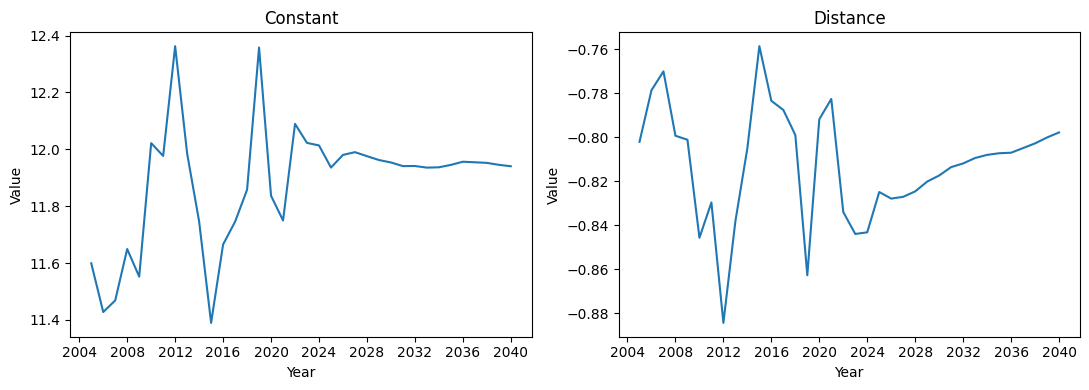

In [545]:
param_df = pd.DataFrame(param_arr, columns=["Year", "const", "distance"])
param_df.set_index("Year", inplace=True)
fig, axes = plt.subplots(1,2, figsize=(11,4), tight_layout=True)
axes[0].plot(param_df["const"])
axes[0].set_title("Constant")
axes[1].plot(param_df["distance"])
axes[1].set_title("Distance")
for i in range(2):
    axes[i].set_xlabel("Year")
    axes[i].set_ylabel("Value")
plt.savefig("reg_evol_all.pdf", format="pdf", dpi=190)

## Focussing on Top Countries by Weight

In [532]:
dg = directed_graph(pd.DataFrame(trade_arr["id"]), wheat_tons, date)
distances_top = add_distances(geog_data_m, dg)
distances_top = distances_top[distances_top["distance"] != 0]

In [658]:
res = fit_linear_model(distances_top)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 weight   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     164.6
Date:                Sun, 14 Apr 2024   Prob (F-statistic):           9.63e-35
Time:                        21:42:46   Log-Likelihood:                -2382.2
No. Observations:                 909   AIC:                             4768.
Df Residuals:                     907   BIC:                             4778.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.9584      0.985     19.254      0.0

In [659]:
resid2 = res.resid.rolling(20).std()
resid_underlying = res.resid

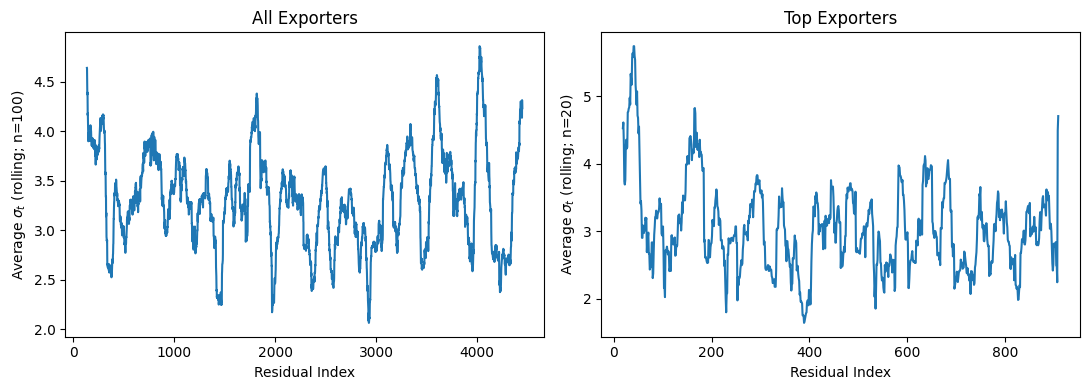

In [654]:
fig, axes = plt.subplots(1,2, figsize=(11,4), tight_layout=True)
axes[0].plot(resid1)
axes[0].set_title("All Exporters")
axes[0].set_xlabel("Residual Index")
axes[0].set_ylabel("Average ${\sigma}_t$ (rolling; n=100)")
axes[1].plot(resid2)
axes[1].set_title("Top Exporters")
axes[1].set_xlabel("Residual Index")
axes[1].set_ylabel("Average ${\sigma}_t$ (rolling; n=20)")
plt.savefig("homoskedasticity.pdf", format="pdf", dpi=190)

In [662]:
import statsmodels.stats.diagnostic as sms
test_result = sms.het_breuschpagan(resid_underlying, res.model.exog, robust=True)
test_result

(12.92474883560006,
 0.0003242661616965393,
 13.082324479619519,
 0.0003145461727814786)

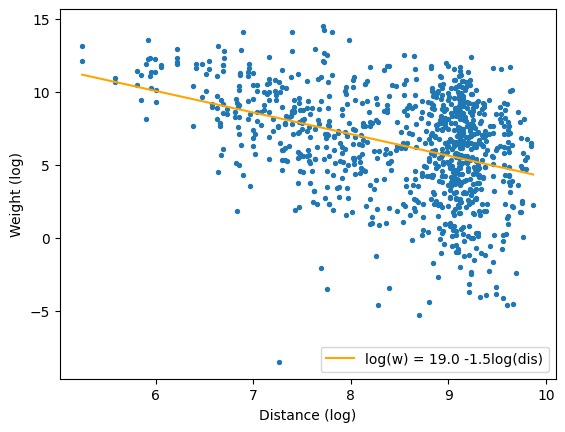

In [541]:
plt.scatter(np.log(distances_top["distance"]), np.log(distances_top["weight"]), s=8)
x = np.linspace(np.log(distances_top["distance"]).min(), np.log(distances_top["distance"]).max(), 100)
plt.plot(x, res.params[0] + res.params[1]*x, color="orange", label=f"log(w) = {round(res.params[0],1)} {round(res.params[1],1)}log(dis)")
plt.ylabel("Weight (log)")
plt.xlabel("Distance (log)")
plt.legend()
plt.savefig("scatter_top.pdf", format="pdf", dpi=190)

In [468]:
date_range = wheat_tons.columns[2:]
yearly_data_top = {}

for date in date_range:
    dg = directed_graph(pd.DataFrame(trade_arr["id"]), wheat_tons, date)
    dist_df = add_distances(geog_data_m, dg)
    yearly_data_top.update({date: dist_df})

save_pickle("yearly_dist_weights_top.pkl", yearly_data_top)

/var/folders/s0/3xfz71116_d8m7n9p2tc7kzc0000gn/T/ipykernel_32515/147977843.py:16: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/var/folders/s0/3xfz71116_d8m7n9p2tc7kzc0000gn/T/ipykernel_32515/147977843.py:16: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/var/folders/s0/3xfz71116_d8m7n9p2tc7kzc0000gn/T/ipykernel_32515/147977843.py:16: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/var/folders/s0/3xfz71116_d8m7n9p2tc7kzc0000gn/T/ipykernel_32515/147977843.py:16: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this 

Dictionary exported successfully.


In [520]:
yearly_data_top = load_pickle("yearly_dist_weights_top.pkl")
param_arr_top = []
for year in yearly_data_top:
    param_arr_top.append([year, *fit_linear_model(yearly_data_top[year]).params])
# Compare to shipping unit costs?

Dictionary imported successfully.


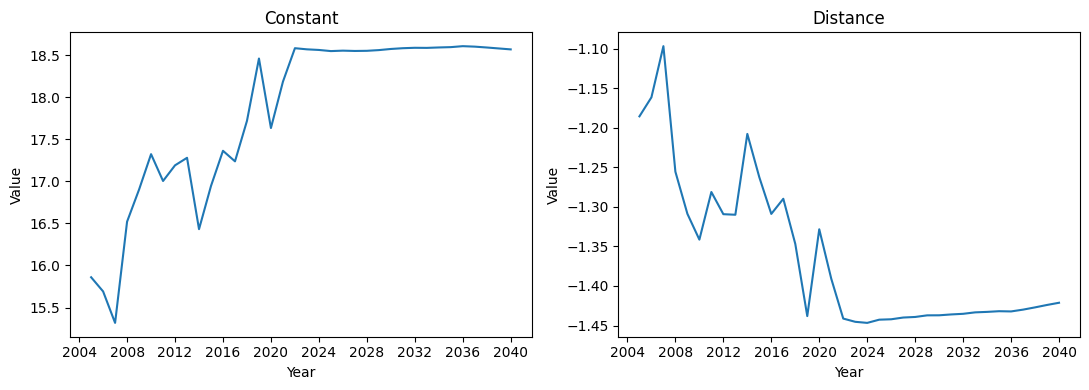

In [544]:
param_df_top = pd.DataFrame(param_arr_top, columns=["Year", "const", "distance"])
param_df_top.set_index("Year", inplace=True)
fig, axes = plt.subplots(1,2, figsize=(11,4), tight_layout=True)
axes[0].plot(param_df_top["const"])
axes[0].set_title("Constant")
axes[1].plot(param_df_top["distance"])
axes[1].set_title("Distance")
for i in range(2):
    axes[i].set_xlabel("Year")
    axes[i].set_ylabel("Value")
plt.savefig("reg_evol_top.pdf", format="pdf", dpi=190)

# Climate Data

- Use Chow test for non-varying regression coefficients across units.
- Isolate into specific groups e.g. exporters to check for their impact with temperature.
- Change the year index.

In [6]:
climate = load_pickle("climate_data_v2.pkl")

Dictionary imported successfully.


In [555]:
imports = wheat_tons[wheat_tons["Exporter"] == "World Total"].drop(columns="Exporter")
exports = wheat_tons[wheat_tons["Importer"] == "World Total"].drop(columns="Importer").bfill()
imports, exports = imports.T, exports.T
imports.columns, exports.columns = imports.loc["Importer"], exports.loc["Exporter"]
imports, exports = imports.iloc[1:], exports.iloc[1:]

In [556]:
imports

Importer,World Total,Aruba,Afghanistan,Angola,Anguilla,Albania,Andorra,Netherlands Antilles,"Oceania, nes.",United Arab Emirates,...,Vietnam,Vanuatu,West Bank,Wallis and Futuna Islands,Western Samoa,Kosovo,Yemen,South Africa,Zambia,Zimbabwe
2005-01-01 00:00:00,25638477.531435,2979.374733,583863.09623,505143.27315,131.409,50950.69508,2878.30571,10508.752066,33.708,49893.791161,...,245815.200049,5010.883061,10912.901001,959.577028,8923.906154,755.277972,52742.053748,131949.613621,10461.064287,319043.989299
2006-01-01 00:00:00,27643912.682373,3765.061808,741459.470111,580625.226921,188.056,44518.009506,2710.251346,11283.868928,19.485,61236.779386,...,275180.793994,5707.938616,6788.762009,880.353673,8152.413766,1631.469892,50841.694947,138749.236704,20483.605349,26146.946948
2007-01-01 00:00:00,30566931.676611,3800.134076,715460.932599,597212.219912,190.446023,38988.867533,2523.164278,11305.192,35.474,106360.295009,...,354630.427568,5097.248071,20859.6521,969.581607,9150.261981,2477.353225,47861.835042,125154.521156,8229.956752,45565.791492
2008-01-01 00:00:00,27439315.311401,4003.470499,871287.396569,577518.288717,181.292125,30248.524436,2423.71944,11577.015559,40.641508,195983.829107,...,299312.725991,4223.589143,108.2,828.098209,8181.033867,2679.904564,39362.050595,145593.41254,10797.379711,84952.459183
2009-01-01 00:00:00,28438308.691944,4117.966756,1212413.603369,631565.509621,178.809555,21474.197571,2307.83316,11148.697904,35.034,160385.439972,...,311139.917509,3904.630445,23.1,912.718785,8285.843551,3106.396828,44977.416773,167473.96132,16130.84987,173928.148255
2010-01-01 00:00:00,29830181.140828,3499.185203,1071586.561843,584716.184676,221.811012,20214.848967,2464.349003,11586.662559,26.824,146444.714174,...,462407.991951,5159.798419,21.0,806.889715,8788.745015,5582.782352,64407.231092,162083.159464,16471.38413,216225.218321
2011-01-01 00:00:00,32915405.808478,4127.380977,1368097.666244,708244.263434,279.991331,23637.385177,2287.766085,4853.472815,29.931,145079.821452,...,396439.717557,6556.477838,1.92,837.300168,8445.606913,8254.169627,57593.422683,189635.619536,10515.914417,194021.696225
2012-01-01 00:00:00,33870998.444694,4695.500008,1441071.884531,750266.393595,194.001672,27353.209175,1909.138634,4877.178409,18.575,159598.247292,...,412475.088895,5731.940777,4.32,755.41722,6645.707241,6624.392265,61577.911516,196560.156781,30432.293232,163943.697912
2013-01-01 00:00:00,33061111.973558,4789.832336,1165141.465153,851894.788485,366.667201,33276.989251,1849.274632,2351.398378,33.735,169893.950054,...,469732.786521,6178.929107,70.680001,811.183463,8296.517307,6761.838568,77586.568946,193557.243436,19149.882904,207026.727241
2014-01-01 00:00:00,33980508.403592,5602.242693,1279940.651043,876301.002482,535.451024,37498.011807,1912.258067,1432.017322,24.095,152779.000404,...,531996.560087,7526.156911,225.592001,856.419929,9727.2513,8403.705525,59356.872969,234136.233832,17240.39418,170332.751364


In [559]:
balance = pd.DataFrame()
for country in countries.iterrows():
    country = country[1][0]
    if country in exports.columns:
        exp = exports[country]
    else:
        exp = 0
    if country in imports.columns:
        imp = imports[country]
    else:
        imp = 0

    balance = pd.concat([balance, exp - imp], axis=1)
balance = balance.astype(float)

In [557]:
def create_climate_df(country, roll=10):
    code = country_codes[country_codes["Country"] == country]["Code"].values[0]
    df = pd.DataFrame()
    for key in climate.keys():
        df = pd.concat([df, climate[key]["data"][code].rename(key)], axis=1)
    if roll:
        return (df - df.rolling(roll).mean()).dropna()
    return df

In [560]:
common_countries = pd.merge(country_codes,pd.Series(balance.columns, name="country"), left_on="Country", right_on="country").drop(columns="country")

def create_dummied_df(country_list, max_date):
    master = pd.DataFrame()
    for country in country_list["Country"]:
        temp = create_climate_df(country)
        temp = temp[temp.index < max_date].astype(float)
        temp["exports"] = exports[country].shift(-2).astype(float)
        temp["country"] = country
        master = pd.concat([master,temp], axis=0)
    df_dummies = pd.get_dummies(master["country"], dtype=float)
    master = pd.concat([master, df_dummies], axis=1)
    return master.dropna()

In [562]:
fe_input = create_dummied_df(common_countries, dt(2023,1,1))

#fe_input.iloc[:,:9].corr()

In [664]:
unit_names = fe_input["country"].drop_duplicates().to_list()
y_var_name = "exports"
X_var_names = ["tas"] + unit_names[:-1]

model = sm.OLS(fe_input[y_var_name], fe_input[X_var_names])
res = model.fit(cov_type='HC3')
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                exports   R-squared (uncentered):                   0.926
Model:                            OLS   Adj. R-squared (uncentered):              0.922
Method:                 Least Squares   F-statistic:                              162.1
Date:                Sun, 14 Apr 2024   Prob (F-statistic):                        0.00
Time:                        21:48:53   Log-Likelihood:                         -43525.
No. Observations:                3258   AIC:                                  8.741e+04
Df Residuals:                    3077   BIC:                                  8.851e+04
Df Model:                         181                                                  
Covariance Type:                  HC3                                                  
                                    coef    std err          z      P>|z|      [0.025      0.975]
----------------------

In [632]:
# ––––––––––––––––– Demeaned Data ------------------ #
def demeaned_data(country_list, max_date, col_name="Country"):
    master = pd.DataFrame()
    for country in country_list[col_name]:
        temp = create_climate_df(country, roll=False)
        temp = temp[(temp.index < max_date) & (temp.index >= dt(2005,1,1))].astype(float)
        temp["exports"] = exports[country].shift(-2).astype(float)
        temp = temp - temp.mean(axis=0)
        temp["country"] = country
        master = pd.concat([master, temp], axis=0)
    return master

demeaned_df = demeaned_data(pd.DataFrame(trade_arr["id"]), max_date=dt(2023,1,1), col_name="id")
u_qunatile = demeaned_df["exports"].quantile(0.98)
l_quantile = demeaned_df["exports"].quantile(0.02)
#demeaned_df = demeaned_df[(demeaned_df["exports"] > l_quantile) & (demeaned_df["exports"] < u_qunatile)]

In [665]:
y_var_name = "exports"
X_var_names = ["tas"]
exog = sm.add_constant(demeaned_df[X_var_names])

model = sm.OLS(demeaned_df[y_var_name], exog)
res = model.fit(cov_type='HC3')
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                exports   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     28.81
Date:                Sun, 14 Apr 2024   Prob (F-statistic):           1.06e-07
Time:                        21:49:03   Log-Likelihood:                -10556.
No. Observations:                 756   AIC:                         2.112e+04
Df Residuals:                     754   BIC:                         2.113e+04
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.637e-11   1.02e+04    1.6e-15      1.0

In [610]:
demeaned_df[y_var_name]

2005-01-01   -8412.229220
2006-01-01   -8379.522971
2007-01-01   -8412.575855
2008-01-01   -8413.004472
2009-01-01   -7969.052234
                 ...     
2018-01-01   -1790.441251
2019-01-01    1997.714510
2020-01-01     546.837807
2021-01-01    2841.366559
2022-01-01    2562.393888
Name: exports, Length: 724, dtype: float64

### Using only the largest producers

In [636]:
big_7 = ["United States", "Russia", "Ukraine", "France", "Germany", "Australia", "Argentina"]
big_7 = pd.DataFrame(big_7, columns=["Country"])
fe_balanced = create_dummied_df(big_7, max_date=dt(2023,1,1))

In [666]:
X_var_names = ["tas", "pr"] + big_7["Country"].to_list()
exog = sm.add_constant(fe_balanced[X_var_names[:-1]])

model = sm.OLS(np.log(fe_balanced["exports"]), fe_balanced[X_var_names[:-1]])
res = model.fit(cov_type='HC3')
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                exports   R-squared (uncentered):                   0.862
Model:                            OLS   Adj. R-squared (uncentered):              0.853
Method:                 Least Squares   F-statistic:                              1746.
Date:                Sun, 14 Apr 2024   Prob (F-statistic):                   1.07e-118
Time:                        21:49:23   Log-Likelihood:                         -386.11
No. Observations:                 126   AIC:                                      788.2
Df Residuals:                     118   BIC:                                      810.9
Df Model:                           8                                                  
Covariance Type:                  HC3                                                  
                    coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------

- Scenario analysis.
- Do a current network and an expected one.

<Axes: >

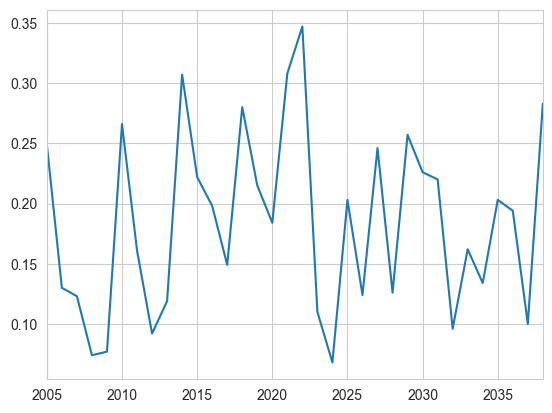

In [147]:
fe_balanced = create_dummied_df(big_7, max_date=dt(2100,1,1))
fe_balanced[fe_balanced["country"] == "United States"]["tas"].plot()

# XGBoost

In [43]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_absolute_percentage_error

def XGB_model(X_train, Y_train, X_test, arch):
    model = XGBRegressor(n_estimators=arch[0], max_depth=arch[1], learning_rate=arch[2])
    res = model.fit(X_train, Y_train)
    Y_hat = model.predict(X_test)

    return Y_hat

def create_master_df(country_list):
    n = -2
    master = pd.DataFrame()
    for country in country_list["Country"]:
        temp = create_climate_df(country)
        temp["balance_m1"] = exports[country].shift(n+1)
        temp["balance"] = exports[country].shift(n)
        temp = temp[temp.index < dt(2023,1,1)]
        master = pd.concat([master,temp], axis=0)

    return master.dropna().astype(float)

In [44]:
xgboost_data = create_master_df(common_countries)
xgboost_data = xgboost_data[xgboost_data["balance"] > 100000]
xgboost_data[["balance", "balance_m1"]] = np.log(xgboost_data[["balance", "balance_m1"]])

X_train, X_test, Y_train, Y_test = train_test_split(xgboost_data.iloc[:,:-1], xgboost_data.iloc[:,-1], test_size=0.2, random_state=10)

In [45]:
estimators = range(7,15)
depth = range(7,15)
alpha = [0.25,0.5,1.5]
param_combos = [element for element in product(estimators, depth, alpha)]
results_tree = []

for params in param_combos:
    model = XGBRegressor(n_estimators=params[0], max_depth=params[1], learning_rate=params[2])
    score = cross_validate(model, X_train, Y_train, cv=5, scoring="neg_mean_squared_error")
    results_tree.append(score)

- Bootstrap this over the test/train datasets to get a distribution of scores.
- Plot the mean value over a series, with a different year used in shifting the data for context.

In [46]:
mod_idx = np.argmax([tree["test_score"].mean() for tree in results_tree])
optimal_model = param_combos[mod_idx]

Y_hat = np.exp(XGB_model(X_train, Y_train, X_test, arch=optimal_model))
score = mean_absolute_percentage_error(Y_hat, np.exp(Y_test))
naive = mean_absolute_percentage_error(np.exp(Y_test), np.exp(X_test["balance_m1"]))
print("Test: ", score, "Naive: ", naive)

Test:  0.17515024353369135 Naive:  0.18726529097965203
